In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pdb
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import h5py

import time
import random
import string
from datetime import datetime

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import torch.optim as optim
import os

from mie2c.e2c import E2C, compute_loss
from mie2c.ball_model import get_ball_encoder, get_ball_decoder, get_ball_transition

### Method to create (3,32,32) tensor

In [3]:
def create_img(X, pos_bounds, radius=0.5, W=32):
    x, y, vx, vy = X

    # Check if center of ball outside image frame
    if x < pos_bounds[0] or x > pos_bounds[1]:
        return None
    elif y < pos_bounds[0] or y > pos_bounds[1]:
        return None

    x_px = int(round(W * x / posbounds[1]))
    y_px = int(round(W * y / posbounds[1]))
    r_px = int(round(radius / pos_bounds[1] * W))

    # Check if perimeter of ball outside image frame
    if x_px+r_px > W or x_px-r_px < 0:
        return None
    elif y_px+r_px > W or y_px-r_px < 0:
        return None

    img = np.ones((3,W,W))
    yy,xx = np.mgrid[:W, :W]
    circle = (xx-x_px)**2 + (yy-y_px)**2
    img[:, circle < r_px**2] = 0.

    th = np.arctan2(vy,vx)
    for rr in range(r_px):
        img[0,int(y_px+rr*np.sin(th)), int(x_px+rr*np.cos(th))] = 1.

    return img

### PWA single integrator kinematics

In [4]:
def step(x0, Ak, add_noise=False):
    update = Ak @ x0
    if add_noise:
        mn = np.array([0.1, 0.1])
        cov = np.diag([0.05, 0.05])
        frzn = stats.multivariate_normal(mn, cov)
        update += frzn.rvs(1)
    return update

### Generate training data

In [679]:
n = 4 
dh = 0.05

posbounds = np.array([0,4]) # 4x4m square
velmax = 10.

Ak = np.eye(n)
Ak[0:int(n/2), int(n/2):] = dh * np.eye(int(n/2))

np.random.seed(12)

W = 32

# Training data
# NUM_DATA = 1000
NUM_DATA = 2

X = np.zeros((NUM_DATA,3,W,W))
X_next = np.zeros((NUM_DATA,3,W,W))

count = 0
while count < NUM_DATA:
    x0 = np.hstack((posbounds[1] * np.random.rand(2), velmax*np.ones(2)))

    img = create_img(x0, posbounds)
    if img is None:
        continue

    x0_new = step(x0, Ak)
    img_new = create_img(x0_new, posbounds)
    if img_new is None:
        continue

    X[count,:,:,:] = img
    X_next[count,:,:,:] = img_new

    count += 1

# Test data
NUM_TEST = 500

X_test = np.zeros((NUM_TEST,3,W,W))
X_next_test = np.zeros((NUM_TEST,3,W,W))

count = 0
while count < NUM_TEST:
    x0 = np.hstack((posbounds[1] * np.random.rand(2), velmax*np.ones(2)))

    img = create_img(x0, posbounds)
    if img is None:
        continue

    x0_new = step(x0, Ak)
    img_new = create_img(x0_new, posbounds)
    if img_new is None:
        continue

    X_test[count,:,:,:] = img
    X_next_test[count,:,:,:] = img_new

    count += 1

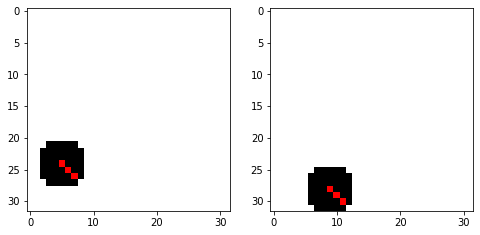

In [680]:
idx = 0
img, img_next = X[idx], X_next[idx]

fig = plt.figure(figsize=(8,8))

fig.add_subplot(1,2,1)
plt.imshow(img.transpose(1,2,0))

fig.add_subplot(1,2,2)
plt.imshow(img_next.transpose(1,2,0))

### Construct encoder/decoder

In [715]:
dim_in = X[0].shape
dim_z = 6
dim_u = 1

encoder = get_ball_encoder(dim_in, dim_z) 
transition = get_ball_transition(dim_z, dim_u)
decoder = get_ball_decoder(dim_z, dim_in) 

model = E2C(encoder, transition, decoder)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


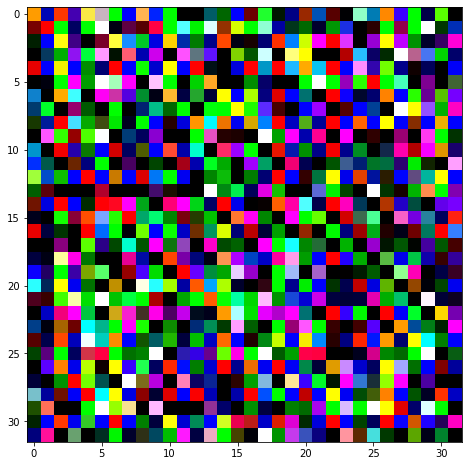

In [716]:
inp = torch.from_numpy(X[:2]).float()
mean, logvar = model.encode(inp)
x_dec = model.decode(mean)[0]

fig = plt.figure(figsize=(8,8))

# fig.add_subplot(1,1,1)
plt.imshow(x_dec.detach().numpy().transpose(1,2,0))

## Training loop

In [717]:
BATCH_SIZE = 200
dataset = torch.utils.data.TensorDataset(torch.tensor(X).float(),torch.tensor(X_next).float())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

optimizer = optim.Adam(model.parameters())

In [815]:
# training parameters
NUM_EPOCH = 500

# KL_LAMBDA = 1.

for epoch in range(NUM_EPOCH):
    ii = 0
    for x, x_next in dataloader:
        optimizer.zero_grad()
        action = torch.zeros((x.shape[0], 1)).float()
        
#         next_pre_rec = model(x, action, x_next)
#         x_dec = model(x, action, x_next)
    
#         loss_rec, loss_trans = compute_loss(\
#             model.x_dec, model.x_next_pred_dec, \
#             x, x_next, \
#             model.Qz, model.Qz_next_pred, model.Qz_next, mse=True)
      
#         loss = loss_rec + KL_LAMBDA * loss_trans

#         loss_rec, loss_trans = compute_loss(\
#             model.x_dec, model.x_next_pred_dec, \
#             x, x_next, \
#             model.Qz, model.Qz_next_pred, model.Qz_next, mse=True)

        model(x, action, x_next)
        loss = compute_loss(model.x_dec, model.x_next_dec, model.x_next_pred_dec, x, x_next, model.Qz, model.Qz_next)

#         print("rec: " + str(loss_rec.item()))
#         print("trans: " + str(loss_trans.item()))
        if ii % 10 == 0:
            print(loss.item())
        
        loss.backward()
        optimizer.step()
        ii += 1

12.776470184326172
12.753822326660156
12.725288391113281
12.70559310913086
12.690254211425781
12.6827392578125
12.667696952819824
12.653350830078125
12.640681266784668
12.638836860656738
12.640918731689453
12.639034271240234
12.644550323486328
12.649358749389648
12.655410766601562
12.66287612915039
12.671184539794922
12.687605857849121
12.716668128967285
12.751623153686523
12.792926788330078
12.854616165161133
12.93979263305664
13.074577331542969
13.205060005187988
13.359140396118164
13.399477005004883
13.40641975402832
13.282692909240723
13.11735725402832
12.896862983703613
12.723201751708984
12.624195098876953
12.617046356201172
12.67658805847168
12.76774787902832
12.865067481994629
12.920607566833496
12.936079025268555
12.87959098815918
12.793533325195312
12.695180892944336
12.62820816040039
12.607341766357422
12.625421524047852
12.662517547607422
12.704558372497559
12.740859031677246
12.749166488647461
12.73612117767334
12.705575942993164
12.672908782958984
12.637950897216797
12.61

12.657889366149902
12.688403129577637
12.712206840515137
12.741077423095703
12.753524780273438
12.76828384399414
12.75320816040039
12.72237777709961
12.674598693847656
12.62898063659668
12.587547302246094
12.552375793457031
12.532029151916504
12.528146743774414
12.538829803466797
12.556154251098633
12.582006454467773
12.608163833618164
12.638748168945312
12.666908264160156
12.700990676879883
12.734809875488281
12.777433395385742
12.805347442626953
12.842364311218262
12.857782363891602
12.866447448730469
12.832734107971191
12.793776512145996
12.723320007324219
12.66451358795166
12.601214408874512
12.560455322265625
12.535179138183594
12.523842811584473
12.519184112548828
12.51947021484375
12.522485733032227
12.528356552124023
12.538667678833008
12.553054809570312
12.579561233520508
12.618549346923828
12.664100646972656
12.700054168701172
12.750112533569336
12.778242111206055
12.80579948425293
12.823139190673828
12.839014053344727
12.813188552856445
12.776826858520508
12.712690353393555


In [816]:
x_pred = model.predict(torch.tensor(X).float(), torch.zeros(NUM_DATA,1).float())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


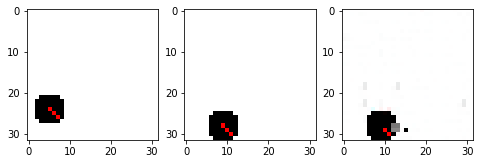

In [822]:
idx = np.random.choice(NUM_DATA)
img, img_next, img_next_pred = X[idx], X_next[idx], x_pred[idx].detach().numpy()

fig = plt.figure(figsize=(8,8))

fig.add_subplot(1,3,1)
plt.imshow(img.transpose(1,2,0))

fig.add_subplot(1,3,2)
plt.imshow(img_next.transpose(1,2,0))

fig.add_subplot(1,3,3)
plt.imshow(img_next_pred.transpose(1,2,0))

In [823]:
x_pred = model.predict(torch.tensor(X_test).float(), torch.zeros(NUM_TEST,1).float())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


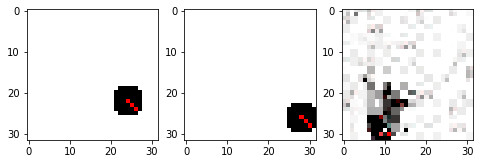

In [829]:
idx = np.random.choice(NUM_TEST)
img, img_next, img_next_pred = X_test[idx], X_next_test[idx], x_pred[idx].detach().numpy()

fig = plt.figure(figsize=(8,8))

fig.add_subplot(1,3,1)
plt.imshow(img.transpose(1,2,0))

fig.add_subplot(1,3,2)
plt.imshow(img_next.transpose(1,2,0))

fig.add_subplot(1,3,3)
plt.imshow(img_next_pred.transpose(1,2,0))